In [1]:
import numpy as np
import xgboost as xgb
import matplotlib.pylab as plt
from sklearn.cross_validation import train_test_split

%matplotlib inline

## Construct a simulated data set for testing monotonic constraints

In [2]:
N, K = (1000, 2)
pi = 3.14159

In [3]:
X = np.random.random(size=(N, K))
y = (5*X[:, 0] + np.sin(5*2*pi*X[:, 0])
     - 5*X[:, 1] - np.cos(5*2*pi*X[:, 1])
     #+ 0.01*np.sin(5*2*pi*X[:, 0])*np.cos(5*2*pi*X[:, 1])
     + np.random.normal(loc=0.0, scale=0.01, size=N))

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

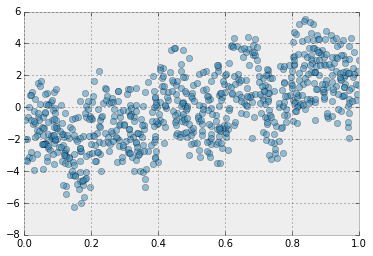

In [5]:
plt.plot(X_train[:, 0], y_train, 'o', alpha = 0.5)

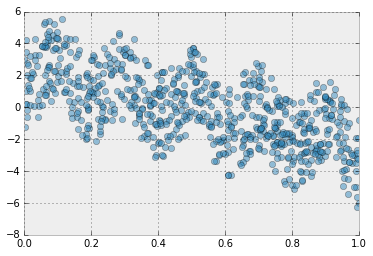

In [6]:
plt.plot(X_train[:, 1], y_train, 'o', alpha = 0.5)

## Fit a xgboost model

Comparisons between constrained and unconstrained models.

In [7]:
params = {
    'max_depth': 2,
    'eta': 0.1,
    'silent': 1,
    'eval_metric': 'rmse',
    'seed': 154
}

Train a xgboost model on only the first feature, the ground truth is a sin wave superimposed on an **increasing** trend.

In [8]:
%%capture

dtrain = xgb.DMatrix(X_train[:, [0]], label = y_train)
dvalid = xgb.DMatrix(X_test[:, [0]], label = y_test)

evallist  = [(dtrain, 'train'), (dvalid, 'eval')]
model_no_constraints = xgb.train(params, dtrain, 
                                 num_boost_round = 1000, evals = evallist, 
                                 early_stopping_rounds = 10)

In [9]:
def plot_one_feature_prediction(bst, X, y, idx=1, title=""):
    """For one-feature model, plot data and prediction."""
    
    x_scan = np.linspace(0, 1, 100)
    x_plot = xgb.DMatrix(x_scan.reshape((len(x_scan),1)))
    y_plot = bst.predict(x_plot, ntree_limit = bst.best_ntree_limit)

    plt.plot(x_scan, y_plot, color = 'black')
    plt.plot(X, y, 'o', alpha = 0.25)

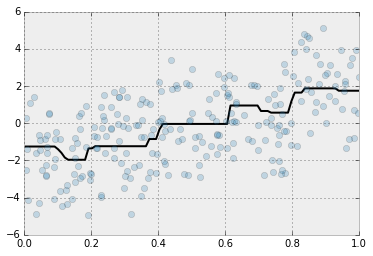

In [10]:
plot_one_feature_prediction(model_no_constraints, X_test[:, 0], y_test, "")

Add a monotonic constraint - constrain feature to be fit monotonically.

In [11]:
%%capture

params_constrained = params.copy()
params_constrained['updater'] = "grow_monotone_colmaker,prune"
params_constrained['monotone_constraints'] = "(1)"

evallist  = [(dtrain, 'train'), (dvalid, 'eval')]
model_with_constraints = xgb.train(params_constrained, dtrain, 
                                 num_boost_round = 1000, evals = evallist, 
                                 early_stopping_rounds = 10)

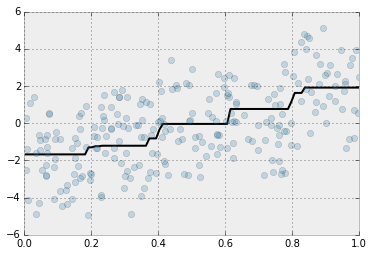

In [12]:
plot_one_feature_prediction(model_with_constraints, X_test[:, 0], y_test, "")

Train a xgboost model on only the first feature, the ground truth is a sin wave superimposed on an **decreasing** trend.

In [13]:
%%capture

dtrain = xgb.DMatrix(X_train[:, [1]], label = y_train)
dvalid = xgb.DMatrix(X_test[:, [1]], label = y_test)

evallist  = [(dtrain, 'train'), (dvalid, 'eval')]
model_no_constraints = xgb.train(params, dtrain, 
                                 num_boost_round = 1000, evals = evallist, 
                                 early_stopping_rounds = 10)

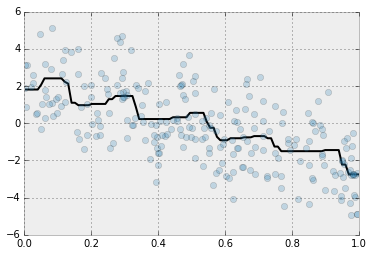

In [14]:
plot_one_feature_prediction(model_no_constraints, X_test[:, 1], y_test, "")

In [15]:
%%capture

params_constrained = params.copy()
params_constrained['updater'] = "grow_monotone_colmaker,prune"
params_constrained['monotone_constraints'] = "(-1)"

evallist  = [(dtrain, 'train'), (dvalid, 'eval')]
model_with_constraints = xgb.train(params_constrained, dtrain, 
                                 num_boost_round = 1000, evals = evallist, 
                                 early_stopping_rounds = 10)

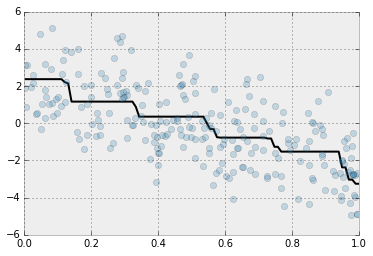

In [16]:
plot_one_feature_prediction(model_with_constraints, X_test[:, 1], y_test, "")

## Two varaible model

Train an xgboost model on **both** features with no constraints.

In [17]:
%%capture

dtrain = xgb.DMatrix(X_train, label = y_train)
dvalid = xgb.DMatrix(X_test, label = y_test)

evallist  = [(dtrain, 'train'), (dvalid, 'eval')]
model_no_constraints = xgb.train(params, dtrain, 
                                 num_boost_round = 2500, evals = evallist, 
                                 early_stopping_rounds = 10)

In [18]:
def plot_one_feature_of_two_prediction(bst, X, y, idx=1, title=""):
    """For one-feature model, plot data and prediction."""
    
    x_scan = np.linspace(0, 1, 100)    
    X_scan = np.empty((100, X.shape[1]))
    X_scan[:, idx] = x_scan
    
    left_feature_means = np.tile(X[:, :idx].mean(axis=0), (100, 1))
    right_feature_means = np.tile(X[:, (idx+1):].mean(axis=0), (100, 1))
    X_scan[:, :idx] = left_feature_means
    X_scan[:, (idx+1):] = right_feature_means
    
    
    X_plot = xgb.DMatrix(X_scan)
    y_plot = bst.predict(X_plot, ntree_limit=bst.best_ntree_limit)

    plt.plot(x_scan, y_plot, color = 'black')
    plt.plot(X[:, idx], y, 'o', alpha = 0.25)

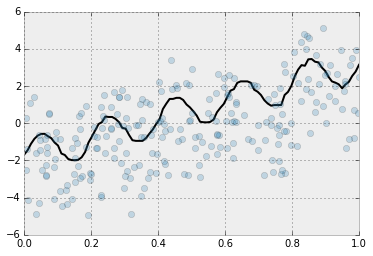

In [19]:
plot_one_feature_of_two_prediction(model_no_constraints, X_test, y_test, 0)

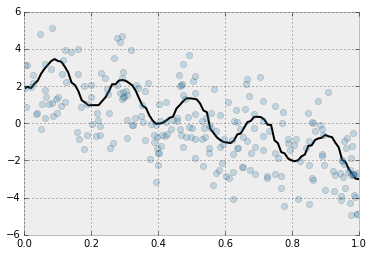

In [20]:
plot_one_feature_of_two_prediction(model_no_constraints, X_test, y_test, 1)

Train an xgboost model on **both** features with monotonic constraints.

In [21]:
%%capture

params_constrained = params.copy()
params_constrained['updater'] = "grow_monotone_colmaker,prune"
params_constrained['monotone_constraints'] = "(1,-1)"

evallist  = [(dtrain, 'train'), (dvalid, 'eval')]
model_with_constraints = xgb.train(params_constrained, dtrain, 
                                   num_boost_round = 2500, evals = evallist, 
                                   early_stopping_rounds = 10)

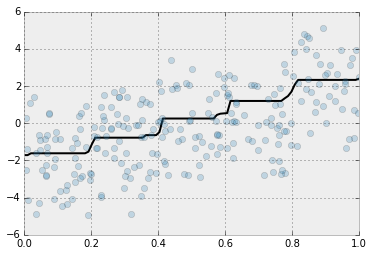

In [22]:
plot_one_feature_of_two_prediction(model_with_constraints, X_test, y_test, 0)

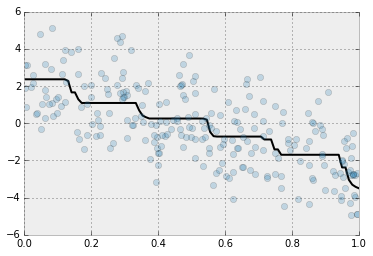

In [23]:
plot_one_feature_of_two_prediction(model_with_constraints, X_test, y_test, 1)

## Speed comparisons with and without monotonic constraints.

Model with no constraints.

In [35]:
%%timeit -n 100
model_no_constraints = xgb.train(params, dtrain, 
                                 num_boost_round = 2500, 
                                 verbose_eval = False)

100 loops, best of 3: 246 ms per loop


In [36]:
%%timeit -n 100
model_with_constraints = xgb.train(params_constrained, dtrain, 
                                 num_boost_round = 2500, 
                                 verbose_eval = False)

100 loops, best of 3: 196 ms per loop
